In [1]:
# ## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_columns', None)

In [3]:
# Create data directory
os.makedirs('/content/data', exist_ok=True)

# Manual upload instructions
print("Please upload all trends_up_to*.csv files and Most+Recent+Cohorts+(Scorecard+Elements).csv")
uploaded = files.upload()

# Move uploaded files to /content/data/
for filename in uploaded.keys():
    os.rename(filename, os.path.join('/content/data', filename))
    print(f"Moved {filename} to /content/data/")

Please upload all trends_up_to*.csv files and Most+Recent+Cohorts+(Scorecard+Elements).csv


Saving CollegeScorecardDataDictionary-09-08-2015.csv to CollegeScorecardDataDictionary-09-08-2015.csv
Saving Most+Recent+Cohorts+(Scorecard+Elements).csv to Most+Recent+Cohorts+(Scorecard+Elements).csv
Saving trends_up_to_inter_6.csv to trends_up_to_inter_6.csv
Saving trends_up_to_UPhoenix.csv to trends_up_to_UPhoenix.csv
Saving trends_up_to_Yorktowne.csv to trends_up_to_Yorktowne.csv
Saving trends_up_to_inter_2.csv to trends_up_to_inter_2.csv
Saving trends_up_to_inter_3.csv to trends_up_to_inter_3.csv
Saving trends_up_to_inter_4.csv to trends_up_to_inter_4.csv
Saving trends_up_to_inter_5.csv to trends_up_to_inter_5.csv
Saving id_name_link.csv to id_name_link.csv
Saving trends_up_to_finish.csv to trends_up_to_finish.csv
Saving trends_up_to_inter_1.csv to trends_up_to_inter_1.csv
Saving trends_up_to_UM.csv to trends_up_to_UM.csv
Saving trends_up_to_UT.csv to trends_up_to_UT.csv
Saving trends_up_to_UTMB.csv to trends_up_to_UTMB.csv
Moved CollegeScorecardDataDictionary-09-08-2015.csv to /

In [4]:
# ## Load Data
# Load trend files and earnings file with diagnostics.

# List trend files
files_trend = glob.glob('/content/data/trends_up_to*.csv')
print(f"Trend files found: {files_trend}")
print(f"Number of trend files: {len(files_trend)}")

# Check if trend files exist
if not files_trend:
    raise FileNotFoundError("No trends_up_to*.csv files found in /content/data/. Please upload the files.")

# Inspect each trend file
print("\nInspecting trend files...")
for file in files_trend:
    df_temp = pd.read_csv(file)
    print(f"File: {file}")
    print(f"  Rows: {len(df_temp)}")
    print(f"  Columns: {df_temp.columns.tolist()}")
    print(f"  Sample:\n{df_temp.head(2)}\n")

# Read and combine trend files
df_num_search = pd.concat([pd.read_csv(f) for f in files_trend], ignore_index=True)
print(f"df_num_search (combined): {len(df_num_search)} rows")
print("df_num_search columns:", df_num_search.columns.tolist())
print("df_num_search sample:\n", df_num_search.head())

# Read earnings data
earnings_file = '/content/data/Most+Recent+Cohorts+(Scorecard+Elements).csv'
if not os.path.exists(earnings_file):
    raise FileNotFoundError(f"Earnings file {earnings_file} not found. Please upload it to /content/data/.")
df_md_earning = pd.read_csv(earnings_file, encoding='latin-1')
print(f"df_md_earning: {len(df_md_earning)} rows")
print("df_md_earning columns:", df_md_earning.columns.tolist())
print("df_md_earning sample:\n", df_md_earning.head())

Trend files found: ['/content/data/trends_up_to_inter_2.csv', '/content/data/trends_up_to_inter_3.csv', '/content/data/trends_up_to_inter_4.csv', '/content/data/trends_up_to_finish.csv', '/content/data/trends_up_to_UTMB.csv', '/content/data/trends_up_to_Yorktowne.csv', '/content/data/trends_up_to_UM.csv', '/content/data/trends_up_to_inter_1.csv', '/content/data/trends_up_to_UPhoenix.csv', '/content/data/trends_up_to_inter_5.csv', '/content/data/trends_up_to_UT.csv', '/content/data/trends_up_to_inter_6.csv']
Number of trend files: 12

Inspecting trend files...
File: /content/data/trends_up_to_inter_2.csv
  Rows: 168242
  Columns: ['schid', 'schname', 'keyword', 'keynum', 'monthorweek', 'index']
  Sample:
   schid                schname                keyword  keynum  \
0    0.0  daytona state college  daytona state college     1.0   
1    0.0  daytona state college  daytona state college     1.0   

               monthorweek  index  
0  2013-04-07 - 2013-04-13   63.0  
1  2013-04-14 - 

In [5]:
# ## Data Wrangling
# Clean data, adapting to missing 'monthorweek'.

# Search trends data
print("\nCleaning df_num_search...")
# Check if data is already aggregated (contains 'schname' and 'n')
if set(df_num_search.columns) == {'schname', 'n'}:
    print("Trend files appear to be pre-aggregated (only 'schname' and 'n' columns). Skipping date processing.")
    df_num_search = df_num_search.apply(lambda x: x.str.upper() if x.dtype == "object" else x)
    print(f"df_num_search after cleaning: {len(df_num_search)} rows")
else:
    # Check for required columns
    if 'monthorweek' not in df_num_search.columns or 'schname' not in df_num_search.columns:
        print("WARNING: Expected columns 'monthorweek' and 'schname' not found.")
        print("Available columns:", df_num_search.columns.tolist())
        print("Please specify the correct date column name (e.g., 'date', 'week') or confirm data is pre-aggregated.")
        raise ValueError("Cannot proceed without 'monthorweek' or equivalent date column.")
    df_num_search = (df_num_search
        .dropna(subset=['schname', 'monthorweek'])
        .assign(week_start=lambda x: pd.to_datetime(x['monthorweek'].str[:10], errors='coerce'))
        .assign(year=lambda x: x['week_start'].dt.year,
                month=lambda x: x['week_start'].dt.month)
        .filter(['schname', 'index', 'year', 'month'])
        .apply(lambda x: x.str.upper() if x.dtype == "object" else x)
        .groupby('schname').size()
        .reset_index(name='n')
    )
    print(f"df_num_search after processing: {len(df_num_search)} rows")
if df_num_search.empty:
    raise ValueError("df_num_search is empty. Check input data or filtering.")
print("Unique schname in df_num_search:", df_num_search['schname'].nunique())
print("Sample schname values:\n", df_num_search['schname'].head())

# Earnings and locality data
print("\nCleaning df_md_earning_locality...")
required_columns = ['UNITID', 'OPEID', 'INSTNM', 'md_earn_wne_p10-REPORTED-EARNINGS', 'LOCALE', 'PREDDEG']
missing_columns = [col for col in required_columns if col not in df_md_earning.columns]
if missing_columns:
    print(f"WARNING: Missing columns in df_md_earning: {missing_columns}")
    print("Available columns:", df_md_earning.columns.tolist())
    raise ValueError("Required columns missing. Update column names in the code.")
print("Unique PREDDEG values:", df_md_earning['PREDDEG'].unique())
df_md_earning_locality = (df_md_earning
    .query('PREDDEG == "3" or PREDDEG == 3')
    .filter(['UNITID', 'OPEID', 'INSTNM', 'md_earn_wne_p10-REPORTED-EARNINGS', 'LOCALE'])
    .rename(columns={'INSTNM': 'schname', 'md_earn_wne_p10-REPORTED-EARNINGS': 'md_earn'})
    .apply(lambda x: x.str.upper() if x.dtype == "object" else x)
    .assign(md_earn=lambda x: pd.to_numeric(x['md_earn'], errors='coerce'))
    .dropna(subset=['schname', 'md_earn', 'LOCALE'])
    .assign(locality=lambda x: x['LOCALE'].map({
        11: 'city_large', 12: 'city_mid', 13: 'city_small',
        21: 'sub_large', 22: 'sub_mid', 23: 'sub_small',
        31: 'town_large', 32: 'town_mid', 33: 'town_small',
        41: 'Rural_large', 42: 'Rural_mid', 43: 'Rural_small'
    }))
)
print(f"df_md_earning_locality: {len(df_md_earning_locality)} rows")
print("Unique LOCALE values:", df_md_earning_locality['LOCALE'].unique())
print("Unique locality values:", df_md_earning_locality['locality'].unique())
if df_md_earning_locality.empty:
    print("WARNING: df_md_earning_locality is empty. Likely issues:")
    print("- PREDDEG filter removed all rows. Check unique PREDDEG values above.")
    print("- Non-numeric md_earn values (e.g., 'PrivacySuppressed') caused all rows to be dropped.")
    print("- Missing LOCALE values.")
    raise ValueError("df_md_earning_locality is empty. See warnings above.")
print("Unique schname in df_md_earning_locality:", df_md_earning_locality['schname'].nunique())
print("Sample schname values:\n", df_md_earning_locality['schname'].head())




Cleaning df_num_search...
df_num_search after processing: 3403 rows
Unique schname in df_num_search: 3403
Sample schname values:
 0                        AANIIIH NAKODA COLLEGE
1                  ABILENE CHRISTIAN UNIVERSITY
2          ABRAHAM BALDWIN AGRICULTURAL COLLEGE
3                               ACADEMY COLLEGE
4    ACADEMY FOR NURSING AND HEALTH OCCUPATIONS
Name: schname, dtype: object

Cleaning df_md_earning_locality...
Unique PREDDEG values: [3 2 1 0 4]
df_md_earning_locality: 1873 rows
Unique LOCALE values: [12. 13. 31. 32. 43. 21. 41. 11. 23. 33. 42. 22.]
Unique locality values: ['city_mid' 'city_small' 'town_large' 'town_mid' 'Rural_small' 'sub_large'
 'Rural_large' 'city_large' 'sub_small' 'town_small' 'Rural_mid' 'sub_mid']
Unique schname in df_md_earning_locality: 1858
Sample schname values:
 0               ALABAMA A & M UNIVERSITY
1    UNIVERSITY OF ALABAMA AT BIRMINGHAM
2                     AMRIDGE UNIVERSITY
3    UNIVERSITY OF ALABAMA IN HUNTSVILLE
4            

In [6]:
# Combine datasets
print("\nMerging datasets...")
common_schnames = set(df_md_earning_locality['schname']).intersection(set(df_num_search['schname']))
print(f"Number of common schname values: {len(common_schnames)}")
if not common_schnames:
    print("WARNING: No common schname values. Sample values:")
    print("df_md_earning_locality schname:", df_md_earning_locality['schname'].head().tolist())
    print("df_num_search schname:", df_num_search['schname'].head().tolist())
    raise ValueError("Merge failed. Check schname consistency.")
df_combined_locality = (df_md_earning_locality
    .merge(df_num_search, on='schname', how='inner')
    .filter(['schname', 'md_earn', 'n', 'locality'])
    .rename(columns={'n': 'num_search'})
)
print(f"df_combined_locality after merge: {len(df_combined_locality)} rows")
if df_combined_locality.empty:
    raise ValueError("df_combined_locality is empty. No matching schname values.")

# Filter for numeric values
df_combined_locality = df_combined_locality[
    df_combined_locality['md_earn'].astype(str).str.match(r'^\d*\.?\d*$') &
    pd.to_numeric(df_combined_locality['num_search'], errors='coerce').notna()
]
df_combined_locality['md_earn'] = df_combined_locality['md_earn'].astype(float)
df_combined_locality['num_search'] = df_combined_locality['num_search'].astype(float)
print(f"df_combined_locality after numeric filter: {len(df_combined_locality)} rows")
if df_combined_locality.empty:
    raise ValueError("df_combined_locality is empty after numeric filtering.")




Merging datasets...
Number of common schname values: 1411
df_combined_locality after merge: 1425 rows
df_combined_locality after numeric filter: 1425 rows


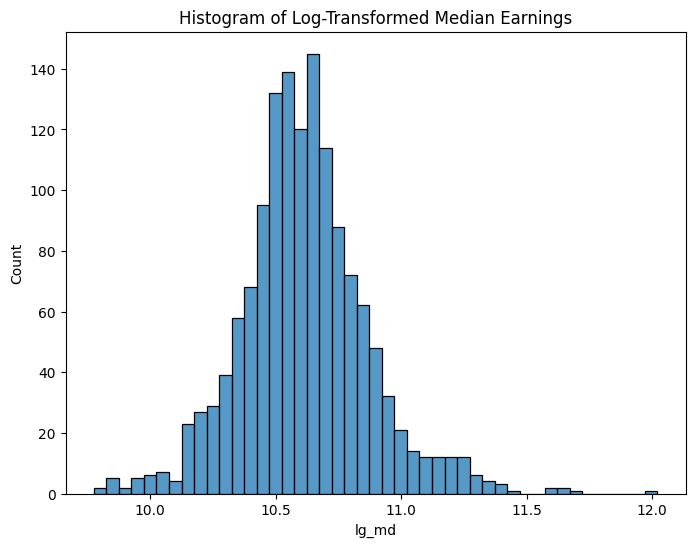

Median of log-transformed earnings: 10.604131561522696
total_school: 1425 rows


In [7]:
# ## Define High- and Low-Earning Colleges
# Use median of log-transformed earnings.

# Standardized earnings (not used)
mean_earning = df_combined_locality['md_earn'].dropna().mean()
std_dev_earning = df_combined_locality['md_earn'].dropna().std()
df_combined_locality['total_earning_sd'] = (df_combined_locality['md_earn'] - mean_earning) / std_dev_earning

# Log-transformed earnings
df_combined_locality['lg_md'] = np.log(df_combined_locality['md_earn'] + 1)
plt.figure(figsize=(8, 6))
sns.histplot(data=df_combined_locality, x='lg_md')
plt.title('Histogram of Log-Transformed Median Earnings')
plt.show()

# Calculate median
md_of_md_earn = df_combined_locality['lg_md'].median()
print(f"Median of log-transformed earnings: {md_of_md_earn}")

# Split into high- and low-earning schools
high_earning = df_combined_locality[df_combined_locality['lg_md'] > md_of_md_earn].copy()
high_earning['earning_code'] = 1
low_earning = df_combined_locality[df_combined_locality['lg_md'] <= md_of_md_earn].copy()
low_earning['earning_code'] = 0
total_school = pd.concat([high_earning, low_earning], ignore_index=True)
print(f"total_school: {len(total_school)} rows")
if total_school.empty:
    raise ValueError("total_school is empty.")


In [8]:
# ## Save Cleaned Datasets
if not df_combined_locality.empty:
    df_combined_locality.to_csv('/content/data/cleaned_df_combined_locality.csv', index=False)
    print("Saved cleaned_df_combined_locality.csv")
    files.download('/content/data/cleaned_df_combined_locality.csv')
else:
    print("WARNING: df_combined_locality is empty. Not saving.")

if not total_school.empty:
    total_school.to_csv('/content/data/cleaned_total_school.csv', index=False)
    print("Saved cleaned_total_school.csv")
    files.download('/content/data/cleaned_total_school.csv')
else:
    print("WARNING: total_school is empty. Not saving.")


Saved cleaned_df_combined_locality.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved cleaned_total_school.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# ## Data Inspection
print("Columns in df_combined_locality:", df_combined_locality.columns.tolist())
print("\nHead of df_combined_locality:\n", df_combined_locality.head())
print("\nSummary of df_combined_locality:\n", df_combined_locality.describe())

print("\nColumns in total_school:", total_school.columns.tolist())
print("\nHead of total_school:\n", total_school.head())
print("\nSummary of total_school:\n", total_school.describe())


Columns in df_combined_locality: ['schname', 'md_earn', 'num_search', 'locality', 'total_earning_sd', 'lg_md']

Head of df_combined_locality:
                                schname  md_earn  num_search  locality  \
0             ALABAMA A & M UNIVERSITY  31400.0       471.0  city_mid   
1  UNIVERSITY OF ALABAMA AT BIRMINGHAM  40300.0       624.0  city_mid   
2                   AMRIDGE UNIVERSITY  38100.0       314.0  city_mid   
3  UNIVERSITY OF ALABAMA IN HUNTSVILLE  46600.0       780.0  city_mid   
4             ALABAMA STATE UNIVERSITY  27800.0       785.0  city_mid   

   total_earning_sd      lg_md  
0         -0.886180  10.354595  
1         -0.151645  10.604132  
2         -0.333215  10.547996  
3          0.368307  10.749377  
4         -1.183295  10.232827  

Summary of df_combined_locality:
              md_earn   num_search  total_earning_sd        lg_md
count    1425.000000  1425.000000      1.425000e+03  1425.000000
mean    42137.403509   512.877193     -1.047116e-16    

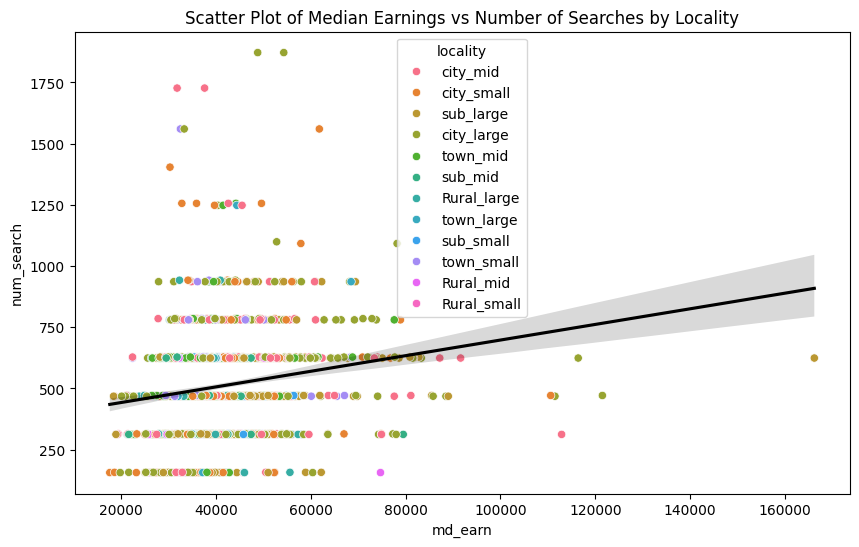

In [10]:
# ## Plot Data
if not total_school.empty:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=total_school, x='md_earn', y='num_search', hue='locality')
    sns.regplot(data=total_school, x='md_earn', y='num_search', scatter=False, color='black')
    plt.title('Scatter Plot of Median Earnings vs Number of Searches by Locality')
    plt.show()
else:
    print("WARNING: Cannot plot data. total_school is empty.")



Regression Summary Table:
 
                           Univariate Log Univariate Multivariate
-----------------------------------------------------------------
Intercept                  479.444*** 6.075***       450.081***  
                           (7.917)    (0.016)        (29.685)    
earning_code               67.007***  0.157***       68.928***   
                           (11.208)   (0.023)        (11.642)    
C(locality)[T.Rural_mid]                             -64.845     
                                                     (50.772)    
C(locality)[T.Rural_small]                           -3.510      
                                                     (63.582)    
C(locality)[T.city_large]                            43.078      
                                                     (31.859)    
C(locality)[T.city_mid]                              50.438      
                                                     (33.536)    
C(locality)[T.city_small]                      

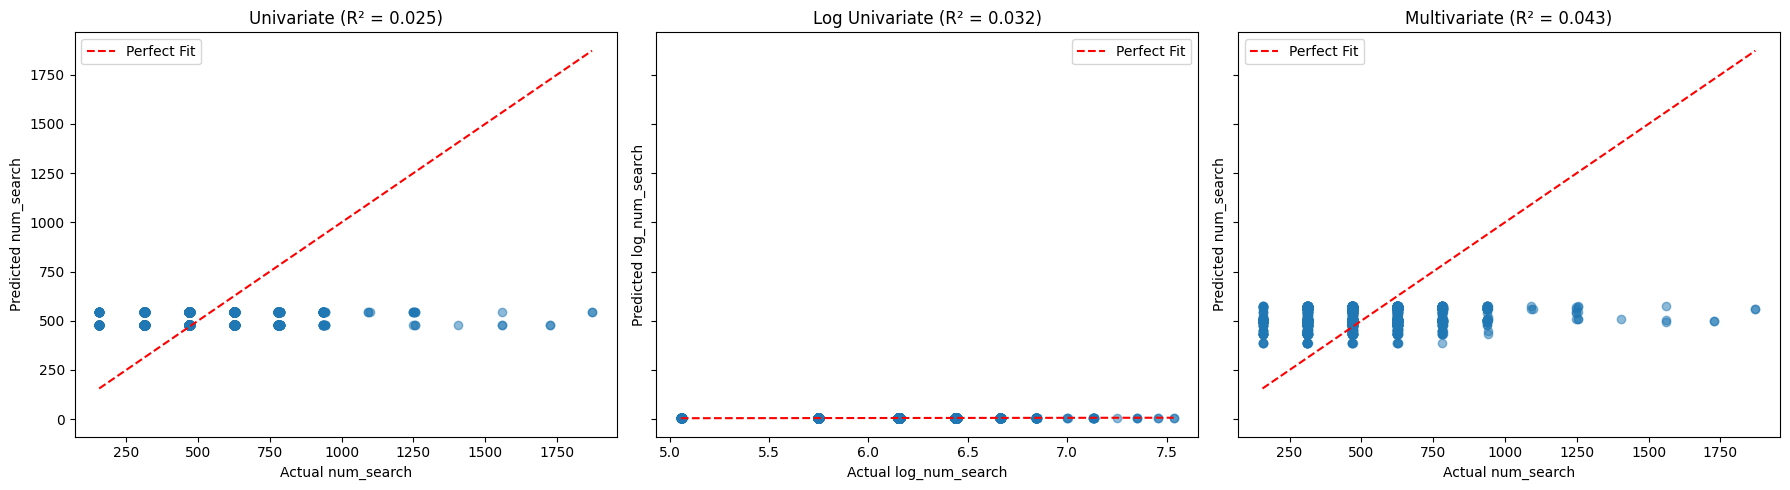

In [24]:
# ## Build and Visualize Regression Models
# Fit regression models and create enhanced visualizations.

if not total_school.empty:
    # Fit models
    reg_total_uni_var = smf.ols('num_search ~ earning_code', data=total_school).fit()
    total_school['log_num_search'] = np.log(total_school['num_search'] + 1)
    reg_total_uni_var_log = smf.ols('log_num_search ~ earning_code', data=total_school).fit()
    reg_total_uni_var_factor = smf.ols('num_search ~ earning_code + C(locality)', data=total_school).fit()

    # Create summary table
    results = summary_col([reg_total_uni_var, reg_total_uni_var_log, reg_total_uni_var_factor],
                          model_names=['Univariate', 'Log Univariate', 'Multivariate'],
                          stars=True,
                          float_format='%.3f',
                          info_dict={'N': lambda x: f"{int(x.nobs)}",
                                     'R²': lambda x: f"{x.rsquared:.3f}",
                                     'Adj R²': lambda x: f"{x.rsquared_adj:.3f}"})
    print("\nRegression Summary Table:\n", results)

    # Prepare data for coefficient bar plot
    coef_data = []
    for model, name in [(reg_total_uni_var, 'Univariate'),
                        (reg_total_uni_var_log, 'Log Univariate'),
                        (reg_total_uni_var_factor, 'Multivariate')]:
        coef = model.params.get('earning_code', 0)
        conf_int = model.conf_int().loc['earning_code'] if 'earning_code' in model.params else [0, 0]
        coef_data.append({
            'Model': name,
            'Coefficient': coef,
            'CI_lower': conf_int[0],
            'CI_upper': conf_int[1]
        })
    coef_df = pd.DataFrame(coef_data)

    # Predicted vs. actual plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    for ax, model, name, y_var in [
        (axes[0], reg_total_uni_var, 'Univariate', 'num_search'),
        (axes[1], reg_total_uni_var_log, 'Log Univariate', 'log_num_search'),
        (axes[2], reg_total_uni_var_factor, 'Multivariate', 'num_search')
    ]:
        preds = model.predict(total_school)
        ax.scatter(total_school[y_var], preds, alpha=0.5)
        ax.plot([total_school[y_var].min(), total_school[y_var].max()],
                [total_school[y_var].min(), total_school[y_var].max()],
                'r--', label='Perfect Fit')
        ax.set_title(f'{name} (R² = {model.rsquared:.3f})')
        ax.set_xlabel(f'Actual {y_var}')
        ax.set_ylabel(f'Predicted {y_var}')
        ax.legend()
    plt.tight_layout()
    plt.show()

    # Locality coefficients for multivariate model
    if 'C(locality)' in reg_total_uni_var_factor.params.index[0]:
        locality_coefs = reg_total_uni_var_factor.params.filter(like='C(locality)')
        locality_conf_int = reg_total_uni_var_factor.conf_int().filter(like='C(locality)')
        locality_df = pd.DataFrame({
            'Coefficient': locality_coefs,
            'CI_lower': locality_conf_int[0],
            'CI_upper': locality_conf_int[1]
        }).reset_index()
        locality_df['Locality'] = locality_df['index'].str.extract(r'C\(locality\)\[T\.(.+)\]')

        plt.figure(figsize=(10, 6))
        sns.barplot(data=locality_df, x='Locality', y='Coefficient', palette='viridis')
        plt.errorbar(x=range(len(locality_df)), y=locality_df['Coefficient'],
                     yerr=[locality_df['Coefficient'] - locality_df['CI_lower'],
                           locality_df['CI_upper'] - locality_df['Coefficient']],
                     fmt='none', c='black', capsize=5)
        plt.axhline(0, color='gray', linestyle='--')
        plt.title('Locality Coefficients in Multivariate Model')
        plt.xlabel('Locality')
        plt.ylabel('Coefficient Estimate')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

else:
    print("WARNING: Cannot run regression models. total_school is empty.")


Univariate Model Summary:
                             OLS Regression Results                            
Dep. Variable:             num_search   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     35.74
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           2.84e-09
Time:                        08:34:12   Log-Likelihood:                -9651.1
No. Observations:                1425   AIC:                         1.931e+04
Df Residuals:                    1423   BIC:                         1.932e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      479.4

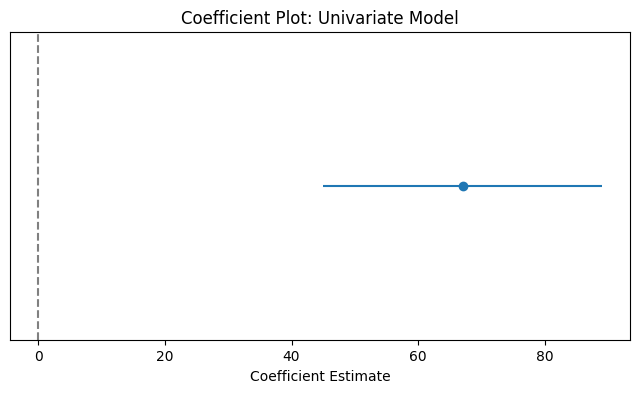


Log-Transformed Univariate Model Summary:
                             OLS Regression Results                            
Dep. Variable:         log_num_search   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     47.44
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           8.49e-12
Time:                        08:34:12   Log-Likelihood:                -820.65
No. Observations:                1425   AIC:                             1645.
Df Residuals:                    1423   BIC:                             1656.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Inte

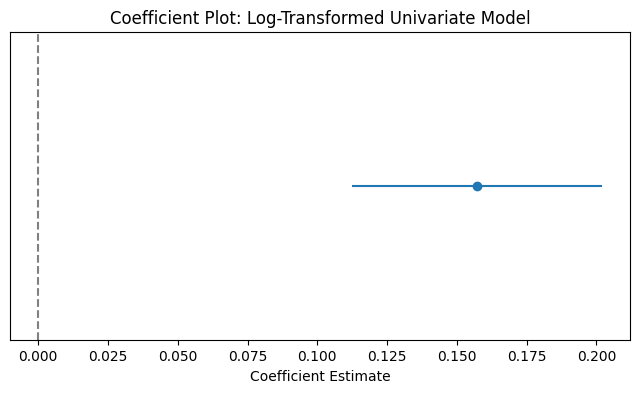


Multivariate Model Summary:
                             OLS Regression Results                            
Dep. Variable:             num_search   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     5.244
Date:                Thu, 07 Aug 2025   Prob (F-statistic):           1.07e-08
Time:                        08:34:12   Log-Likelihood:                -9637.7
No. Observations:                1425   AIC:                         1.930e+04
Df Residuals:                    1412   BIC:                         1.937e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

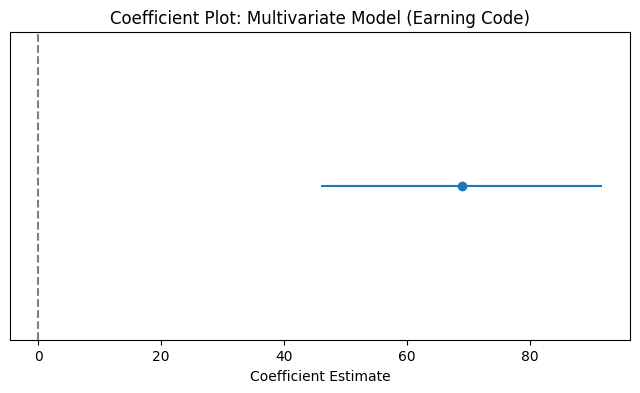


Model Comparison:
 
                            Univariate Log Univariate Multivariate
------------------------------------------------------------------
Intercept                  479.4440*** 6.0749***      450.0813*** 
                           (7.9169)    (0.0161)       (29.6850)   
earning_code               67.0075***  0.1572***      68.9284***  
                           (11.2080)   (0.0228)       (11.6422)   
C(locality)[T.Rural_mid]                              -64.8450    
                                                      (50.7720)   
C(locality)[T.Rural_small]                            -3.5099     
                                                      (63.5821)   
C(locality)[T.city_large]                             43.0782     
                                                      (31.8589)   
C(locality)[T.city_mid]                               50.4383     
                                                      (33.5356)   
C(locality)[T.city_small]                

In [23]:

    # Model 1: Univariate
print("\nUnivariate Model Summary:\n", reg_total_uni_var.summary())

plt.figure(figsize=(8, 4))
coef = reg_total_uni_var.params['earning_code']
conf_int = reg_total_uni_var.conf_int().loc['earning_code']
plt.errorbar(y=0, x=coef, xerr=[[coef - conf_int[0]], [conf_int[1] - coef]], fmt='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Coefficient Plot: Univariate Model')
plt.xlabel('Coefficient Estimate')
plt.yticks([])
plt.show()

    # Model 2: Log-transformed
print("\nLog-Transformed Univariate Model Summary:\n", reg_total_uni_var_log.summary())

plt.figure(figsize=(8, 4))
coef_log = reg_total_uni_var_log.params['earning_code']
conf_int_log = reg_total_uni_var_log.conf_int().loc['earning_code']
plt.errorbar(y=0, x=coef_log, xerr=[[coef_log - conf_int_log[0]], [conf_int_log[1] - coef_log]], fmt='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Coefficient Plot: Log-Transformed Univariate Model')
plt.xlabel('Coefficient Estimate')
plt.yticks([])
plt.show()

    # Model 3: Multivariate
print("\nMultivariate Model Summary:\n", reg_total_uni_var_factor.summary())

plt.figure(figsize=(8, 4))
coef_factor = reg_total_uni_var_factor.params['earning_code']
conf_int_factor = reg_total_uni_var_factor.conf_int().loc['earning_code']
plt.errorbar(y=0, x=coef_factor, xerr=[[coef_factor - conf_int_factor[0]], [conf_int_factor[1] - coef_factor]], fmt='o')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Coefficient Plot: Multivariate Model (Earning Code)')
plt.xlabel('Coefficient Estimate')
plt.yticks([])
plt.show()

    # Compare models
print("\nModel Comparison:\n", summary_col([reg_total_uni_var, reg_total_uni_var_log, reg_total_uni_var_factor],
                                            model_names=['Univariate', 'Log Univariate', 'Multivariate'],
                                            stars=True))